In [1]:
%matplotlib inline

In [2]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import nengo
from nengolib.synapses import ss2sim
import numpy as np
import seaborn as sns

In [3]:
factorial = np.vectorize(np.math.factorial)

In [4]:
from cue.utils.plotting import *

In [5]:
style()

## Noise reconstruction example

In [6]:
n_max = 140
c = 0.05
tau_star_min = -0.02
tau_stars = tau_star_min * (1 + c)**np.arange(n_max)

In [7]:
k = 8
ss = -k / tau_star_min / (1 + c)**(np.arange(n_max + 2 * k) - k)
ss_ = ss[k:-k]
ss_diff = np.diff(ss)
ss_diff2 = ss_diff[:-1] + ss_diff[1:]
f1 = ss_diff[:-1] / ss_diff[1:] / ss_diff2
f2 = ss_diff[1:] / ss_diff[:-1] / ss_diff2
a_ = np.diag(-np.concatenate((f2, (0,))), k=-1)
b_ = np.diag(np.concatenate(((0,), f2 - f1, (0,))))
c_ = np.diag(np.concatenate(((0,), f1)), k=1)
D1 = (a_ + b_ + c_)[1:-1]
Dk = np.eye(D1.shape[1])
for i in range(k):
    if i > 0:
        Dk = D1[i:-i, i:-i] @ Dk
    else:
        Dk = D1 @ Dk

Lk = (-1)**k / factorial(k) * (ss_[:, None])**(k+1) * Dk

In [8]:
dt = 0.001

A = np.diag(-ss)
B = np.ones((len(ss), 1))
C = np.eye(len(ss))
D = np.zeros((len(ss), 1))

In [9]:
synapse = nengo.Lowpass(0.1)
sys = ss2sim((A, B, C, D), synapse, dt)

In [10]:
with nengo.Network() as model:
    inp = nengo.Node(1.)
    state = nengo.networks.EnsembleArray(1, len(ss), neuron_type=nengo.Direct())

    nengo.Connection(inp, state.input, transform=sys.B, synapse=synapse)
    nengo.Connection(state.output, state.input, transform=sys.A, synapse=synapse)

    p = nengo.Probe(state.output)

In [11]:
with nengo.Simulator(model) as sim:
    sim.run(200.)

Building finished in 0:00:01.                                                                                           
Simulating finished in 0:00:58.                                                                                         


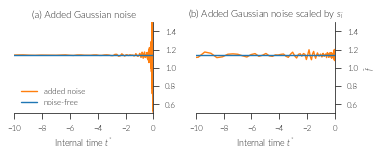

In [12]:
t = -1

fig = plt.figure(figsize=(textwidth, row_height))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(tau_stars, Lk @ (sim.data[p][t] + 5e-9 * np.random.randn(sim.data[p].shape[1])), color='C1', label='added noise')
ax1.plot(tau_stars, Lk @ sim.data[p][t], color='C0', label='noise-free')
ax1.legend(loc='lower left')
ax1.set_title("(a) Added Gaussian noise")

ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
ax2.plot(tau_stars, Lk @ (sim.data[p][t] + 1. / ss * 5e-8 * np.random.randn(sim.data[p].shape[1])), color='C1')
ax2.plot(tau_stars, Lk @ sim.data[p][t], color='C0')
ax2.set_title(r"(b) Added Gaussian noise scaled by $s_i$")

ax2.set_xlim(-10., 0.)
ax2.set_ylim(0.5, 1.5)

ax1.set_xlabel(r"Internal time $t^*$")
ax2.set_xlabel(r"Internal time $t^*$")
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r"$\hat f$")

sns.despine(fig, left=True, right=False)
fig.tight_layout()

In [ ]:
save_tight_fig(fig, '../../../phd-thesis/figures/fuzzy-mem-noise-example.pdf')

## Noise amplification and timescale

In [13]:
def noise_amplification(c, k):
    return np.sqrt(2.)**k / factorial(k) / c**k 

In [14]:
def timescale(c, k, tau_star=-1.):
    return -(1 + c)**k * tau_star

In [15]:
cs = np.linspace(0.0, 2., 100, endpoint=False)
cs += cs[1]
ks = np.arange(1, 20)
C, K = np.meshgrid(cs, ks)

In [16]:
ampl = 10 * np.log10(noise_amplification(C, K))
tscale = timescale(C, K)

In [21]:
from matplotlib.colors import LogNorm

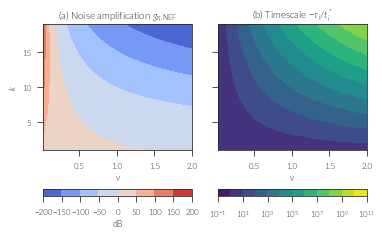

In [24]:
fig = plt.figure(figsize=(textwidth, 1.5 * row_height))

ax1 = fig.add_subplot(1, 2, 1)
v = np.max(np.abs(ampl))
c1 = ax1.contourf(C, K, ampl, cmap='coolwarm', vmin=-v, vmax=v)
cb1 = fig.colorbar(c1, ax=ax1, orientation='horizontal', pad=0.2)

ax1.set_title(r"(a) Noise amplification $g_{\eta,\mathrm{NEF}}$")
ax1.set_xlabel(r"$\nu$")
ax1.set_ylabel(r"$k$")
cb1.set_label("dB")

ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
c2 = ax2.contourf(C, K, tscale, locator=ticker.LogLocator(), cmap='viridis')
cb2 = fig.colorbar(c2, ax=ax2, orientation='horizontal', pad=0.2)

ax2.set_title(r"(b) Timescale $-\tau_i / t^*_i$")
ax2.set_xlabel(r"$\nu$")
for label in ax2.yaxis.get_ticklabels():
    label.set_visible(False)

fig.tight_layout()

In [111]:
save_tight_fig(fig, '../../../phd-thesis/figures/fuzzy-mem-noise-ts.pdf')

## Number of neurons

In [25]:
ts = 1.
duration = -10.
N = 50
d = 64

In [26]:
tau_stars = -np.linspace(1e-2, 1., endpoint=False, num=200)
ks = np.arange(1, 20)
T, K = np.meshgrid(tau_stars, ks)

In [44]:
nu = (-ts / T)**(1./K) - 1.
M = np.log(duration / T) / np.log(1 + nu)
z = noise_amplification(nu, K)**2 * (M + 2 * K)

In [45]:
class EngNumFormatter(ticker.EngFormatter):
    ENG_PREFIXES = {p: r"$\cdot 10^{{{}}}$".format(p) if p != 0 else "" for p in ticker.EngFormatter.ENG_PREFIXES.keys()}

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


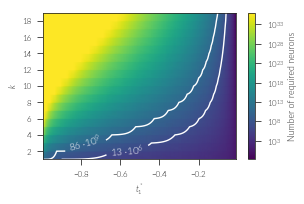

In [46]:
fig = plt.figure(figsize=(single_fig_size[0] * 1.2, 1.3 * single_fig_size[1]))

ax = fig.add_subplot(1, 1, 1)
#cf = ax.contourf(T, K, N * d * z, locator=ticker.LogLocator(), cmap='viridis', vmin=N * d)
cf = ax.pcolormesh(T, K, N * d * z, norm=LogNorm(vmax=1e36), cmap='viridis', shading='gouraud')
cl = ax.contour(T, K, N * d * z, locator=ticker.LogLocator(), vmax=1e18, levels=[13e6, 86e9], colors='white')
ax.clabel(cl, fmt=EngNumFormatter(), inline_spacing=10)

ax.set_xlabel(r"$t_1^*$")
ax.set_ylabel(r"$k$")

cb = fig.colorbar(cf, ax=ax)
cb.set_label("Number of required neurons")

fig.tight_layout()

In [47]:
save_tight_fig(fig, '../../../phd-thesis/figures/fuzzy-mem-n-neurons.pdf')

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
